# [IAPR 2020:][iapr2020] Lab 1 ‒  Image segmentation

**Author:** Wei JIANG, Minghui SHI, Costanza VOLPINI 

**Due date:** 27.03.2020

[iapr2018]: https://github.com/LTS5/iapr-2020

## Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [38]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

In [39]:
# Additional imports
import numpy as np;
import matplotlib.pyplot as plt
%matplotlib inline

# scipy
from scipy import ndimage
from scipy.stats import mode

# sklearn
from sklearn.cluster import KMeans, MeanShift

# opencv
import cv2 # OpenCV library
from cv2 import adaptiveThreshold


# skimage
import skimage.io
import skimage.viewer
import skimage.measure
from skimage.color import rgb2hsv, hsv2rgb


## Part 1: Brain segmentation

Your goal: compute the size of the brain (in pixels) in a 2D image of a human head taken by Magnetic Resonance Imaging (MRI).
* Try as many methods as you can, the more the better.
* At least region growing and contour detection.

### 1.1 Brain image visualization

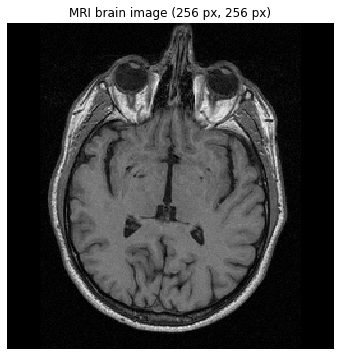

In [40]:
# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

### 1.2 Region growing
Add your implementation and discussion

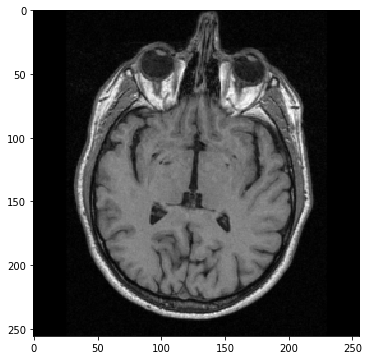

In [41]:
# Using Gaussian filter to denoise image
brain_denoise = cv2.GaussianBlur(brain_im,(5,5),0.5,0.5)
plt.figure(figsize=[6,6])
plt.imshow(brain_denoise,cmap='gray')

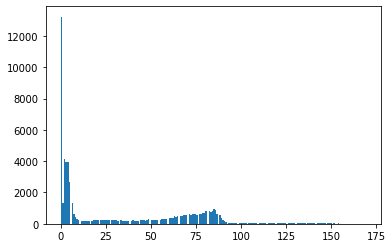

In [42]:
plt.hist(brain_denoise.ravel(),bins=200)
plt.show()

In [43]:
def region_growing(img, seed, threshold):

    img = np.float32(img)
    
    # 8-connected growing method
    neighbors = [(-1, 0), (1, 0), (0, -1), (0, 1),(-1,-1),(-1,1),(1,1),(1,-1)]
    region_size = 1
    neighbor_points_list = []
    neighbor_points_list.append(seed)
    
    #Initialize segmented output image
    height,width = img.shape
    segmented_img = np.zeros((height, width), np.uint8)
    
    while len(neighbor_points_list) != 0:  
        
        seed = neighbor_points_list.pop(0)
        for i in range(8):
            
            #Compute the neighbor pixel position
            x_new = seed[0] + neighbors[i][0]
            y_new = seed[1] + neighbors[i][1]
            
            checkout = (x_new >= 0) & (y_new >= 0) & (x_new < height) & (y_new < width)
            if checkout:
                if segmented_img[x_new, y_new] == 0:
                    
                    # compute difference
                    difference = np.abs(img[x_new,y_new]-img[seed[0],seed[1]])
                    
                    if difference <= threshold:
                        
                        neighbor_points_list.append([x_new,y_new])
                        segmented_img[x_new, y_new] = 255
                        region_size+=1
                        
    return segmented_img,region_size

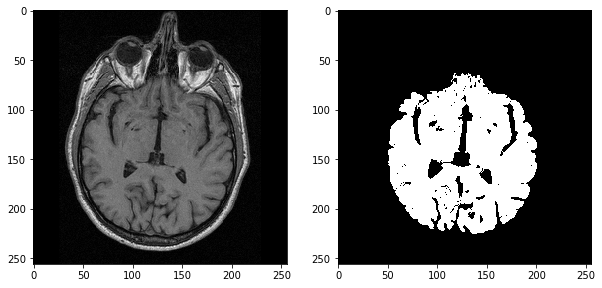

In [44]:
# set seed
seed = [153,82]
segmented_img, region_size = region_growing(brain_denoise, seed, 4)
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(brain_im, cmap='gray')
ax[1].imshow(segmented_img,cmap='gray')
plt.show()

In [45]:
print("The brain size is ",region_size)

The brain size is  16117


##### 1.3 Contour detection
Add your implementation and discussion

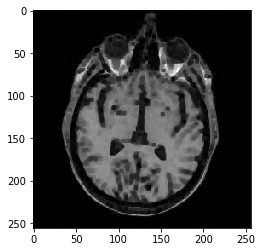

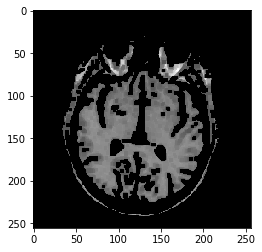

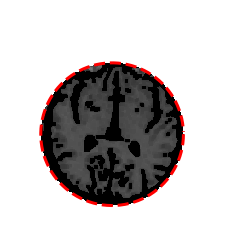

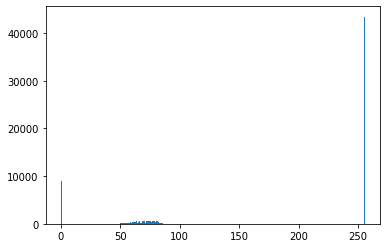

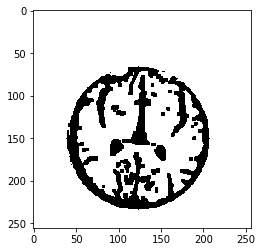

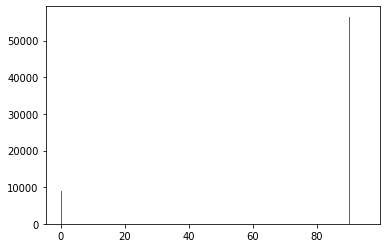

In [46]:
from scipy.ndimage import grey_erosion, grey_dilation
brain_processing = grey_erosion(brain_im, size = (4,4))
plt.imshow(brain_processing,'gray')
plt.show()

# remove dark gray and black by thresholding
brain_processing[brain_processing<50] = 0 # reduce noise

plt.imshow(brain_processing,'gray')
plt.show()

# detect circle brain --> background white
def circle_points(resolution, center, radius):
    """
    Generate points which define a circle on an image.Centre refers to the centre of the circle
    """   
    radians = np.linspace(0, 2*np.pi, resolution)
    c = center[1] + radius*np.cos(radians)#polar co-ordinates
    r = center[0] + radius*np.sin(radians)
    
    return np.array([c, r]).T
# Exclude last point because a closed path should not have duplicate points
xc = 123
yc = 150
radius = 84
points = circle_points(200, [150, 123], 84)[:-1]

def image_show(image, nrows=1, ncols=1, cmap='gray'):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4, 4))
    ax.imshow(image, cmap='gray')
    ax.axis('off')
    return fig, ax

fig, ax = image_show(brain_processing)
ax.plot(points[:, 0], points[:, 1], '--r', lw=3)

for y in range(brain_processing.shape[0]):
    for x in range(brain_processing.shape[1]):
        if ((x - xc) ** 2 + (y - yc) ** 2) > radius ** 2:
            brain_processing[y][x] = 255;
    
plt.imshow(brain_processing,'gray')
plt.show()

plt.hist(brain_processing.ravel(), 256,[0,256]);
plt.show()


# from the histogram we can see that we have a lot of values at 0, 255 and between 30 to 100 --> we want to have just 2 values (0 and 90)
brain_processing[brain_processing > 30] = 90

brain_processing = grey_dilation(brain_processing, size = (1,1))

plt.imshow(brain_processing,'gray')
plt.show()

# plt.hist(brain_processing.ravel(), 256,[0,256]); #double check we have no values at 255

plt.hist(brain_processing.ravel(), 256,[0,95]);

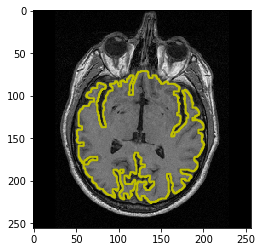

In [47]:
from skimage import measure
from cv2 import fillPoly
# find constant valued contours in an image. Array values are linearly interpolated to provide 
# better precision of the output contours.
# contours at constant value 0.8
contours = measure.find_contours(brain_processing, 0.8)

# https://stackoverflow.com/questions/39642680/create-mask-from-skimage-contour
# Select the largest contiguous contour
contour = sorted(contours, key=lambda x: len(x))[-1]

# Display the image and plot the contour
fig, ax = plt.subplots()
ax.imshow(brain_im, interpolation='nearest', cmap=plt.cm.gray)
X, Y = ax.get_xlim(), ax.get_ylim()
ax.step(contour.T[1], contour.T[0], linewidth=2, c='y')
ax.set_xlim(X), ax.set_ylim(Y)
plt.show()


Brain area is:  16028


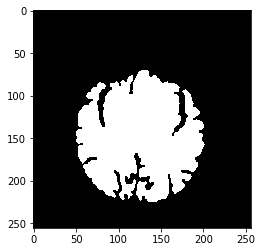

In [48]:
# compute area inside (https://stackoverflow.com/questions/39642680/create-mask-from-skimage-contour)
import scipy.ndimage as ndimage    

# Create an empty image to store the masked array
r_mask = np.zeros_like(brain_im, dtype='bool')

# Create a contour image by using the contour coordinates rounded to their nearest integer value
r_mask[np.round(contour[:, 0]).astype('int'), np.round(contour[:, 1]).astype('int')] = 1

# Fill in the hole created by the contour boundary
r_mask = ndimage.binary_fill_holes(r_mask)

# Invert the mask since you want pixels outside of the region
# r_mask = ~r_mask
plt.imshow(r_mask, cmap=plt.cm.gray)

area_brain_tot = np.sum(r_mask) # tot True in mask

print("Brain area is: ", area_brain_tot)

Brain area is:  16482.5


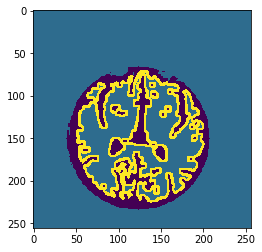

In [49]:
# Find the contour of the brain with opencv (https://towardsdatascience.com/computer-vision-for-beginners-part-4-64a8d9856208)
img = brain_processing.copy()
contours, hierarchy = cv2.findContours(
                                   image = img, 
                                   mode = cv2.RETR_TREE, 
                                   method = cv2.CHAIN_APPROX_SIMPLE)

# Sort the contours 
contours = sorted(contours, key = cv2.contourArea, reverse = True)
# print(len(contours)) # 29
contours = contours[2:22];
# we are interested to contours[2] (brain), details of brain: contours[3], contours[4], contours[5], contours[6], ... contours[20] --> just select brain

# Draw the contour 
img_copy = img.copy()
final = cv2.drawContours(img_copy, contours, contourIdx = -1, 
                         color = (255, 0, 0), thickness = 2)
plt.imshow(img_copy)

# The area of contours 
area_brain_tot = 0;
for i in range(len(contours)):
    area_brain_tot = area_brain_tot + cv2.contourArea(contours[i])
    
print("Brain area is: ", area_brain_tot)

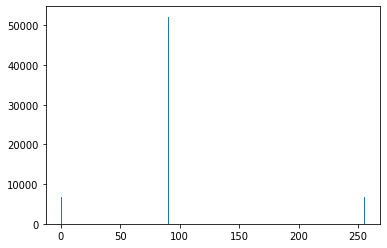

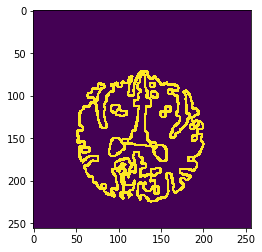

In [50]:
# remove part outside brain (just graphically)
plt.hist(img_copy.ravel(), 256,[0,256]);
plt.show()

img_copy[img_copy < 150] = 0;

plt.imshow(img_copy)


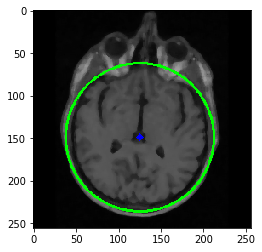

In [51]:
# Brain detection by edge using canny
# use Hough Transform to find circles in an image --> our bain
img = cv2.medianBlur(brain_im.copy(),5)
cimg = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR) #convert to grayscale

# dp – Inverse ratio of the accumulator resolution to the image resolution. 
# minDist – Minimum distance between the centers of the detected circles. If the parameter is too small, multiple neighbor circles may be falsely detected in addition to a true one. If it is too large, some circles may be missed.
# param1: it is the higher threshold of the two passed to the Canny() edge detector. (same as threshold of canny)
# param2: it is the accumulator threshold for the circle centers at the detection stage. The smaller it is, the more false circles may be detected. Circles, corresponding to the larger accumulator values, will be returned first.
circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT, dp=4.9, minDist=300,
                            param1=90, param2=55 ,minRadius=0 ,maxRadius=0)

circles = np.uint16(np.around(circles))
for i in circles[0,:]:
    # draw the outer circle
    cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
    # draw the center of the circle
    cv2.circle(cimg,(i[0],i[1]),2,(0,0,255),3)

plt.imshow(cimg, cmap='gray')
plt.show()

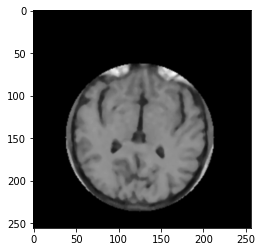

In [52]:
from math import hypot

# Create a mask (https://stackoverflow.com/questions/34290781/how-to-mask-circular-area)
circles = np.uint16(np.around(circles))

x, y, r = circles[0,:][0]
rows, cols = img.shape

for i in range(cols):
    for j in range(rows):
        if hypot(i-x, j-y) > r:
            img[j,i] = 0

plt.imshow(img, cmap='gray', interpolation = 'bicubic')
plt.show()

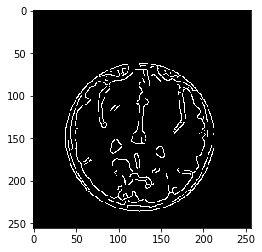

In [53]:
from skimage import feature

edges_mask = skimage.feature.canny(
    image=img,
    sigma=.8,
    low_threshold=30,
    high_threshold=50,
)

# display edges
plt.imshow(edges_mask, cmap='gray')
plt.show()

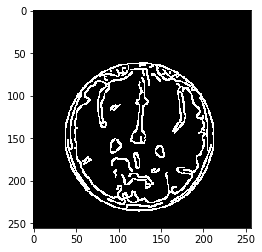

In [54]:
# dilation
kernel_22 = np.ones((2,2), np.uint8)
brain_mask_dilation = ndimage.binary_dilation(edges_mask, kernel_22, iterations=1) 
plt.imshow(brain_mask_dilation, cmap='gray')

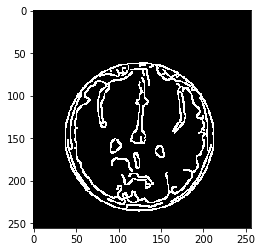

In [55]:
from scipy import ndimage as ndi
from skimage import morphology

remove_small_objs_brain = morphology.remove_small_objects(brain_mask_dilation.astype(bool), min_size=90)

# remove_small_objs_brain = 1 - remove_small_objs_brain
plt.imshow(remove_small_objs_brain, cmap='gray')

The number of pixels counted as the brain are 5654.


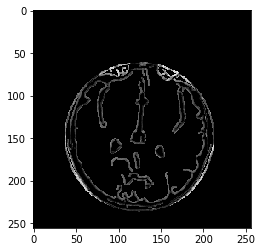

In [56]:
print('The number of pixels counted as the brain are {}.'.format(np.sum(remove_small_objs_brain)))
overlap_brain = brain_im & (remove_small_objs_brain*255)
plt.imshow(overlap_brain, cmap='gray')

# plt.hist(compare_images.ravel(), 256,[0,256]);
# plt.show()

# Threshold
# def threshold(t1, t2, img):

In [57]:
# Threshold
def threshold(t1, t2, img):
    th_img = img.copy()
    th_img[th_img < t1] = 0
    th_img[th_img > t2] = 0
    th_img[(th_img >= t1) & (th_img <= t2)] = 1
    return th_img

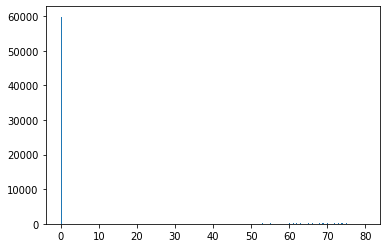

In [58]:
plt.hist(overlap_brain.ravel(), 256,[0,80]);
brain_diff_threshold = threshold(10, 100, overlap_brain)

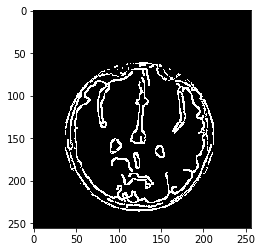

In [59]:
plt.imshow(brain_diff_threshold, cmap='gray')

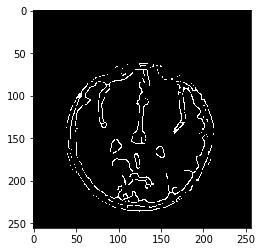

In [60]:
brain_processing = brain_diff_threshold.copy()

kernel_44 = np.ones((2,2), np.uint8) 
kernel2 = np.ones((2,1), np.uint8) 
kernel3 = np.ones((2,2), np.uint8) 


# The first parameter is the original image, 
# kernel is the matrix with which image is  
# convolved and third parameter is the number  
# of iterations, which will determine how much  
# you want to erode/dilate a given image.  
# img_erosion = cv2.erode(i_thresholded, kernel, iterations=1) 
# img_dilation = cv2.dilate(img_erosion, kernel, iterations=1) 

from scipy import ndimage
brain_processing = ndimage.binary_opening(brain_processing, kernel_22, iterations=1) 
brain_processing = ndimage.binary_erosion(brain_processing, kernel_22, iterations=1)
brain_processing = ndimage.binary_closing(brain_processing, kernel_22, iterations=1) 



plt.imshow(brain_processing, cmap='gray')

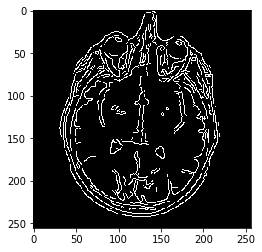

In [61]:
# Canny algorithm
# 1) Nois reduction
# 2) Gradient calculation
# 3) Non-maximum suppression
# 4) Double threshold
# 5) Edge Tracking by Hysteresis

from skimage import feature

edges = skimage.feature.canny(
    image=brain_im,
    sigma=.8,
    low_threshold=55,
    high_threshold=90,
)

# display edges
plt.imshow(edges, cmap='gray')
plt.show()

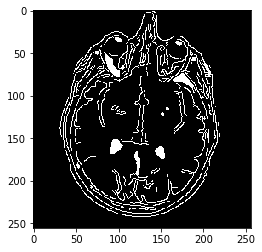

In [62]:
from scipy import ndimage as ndi
fill_brain = ndi.binary_fill_holes(edges)

plt.imshow(fill_brain, cmap='gray')
plt.show()

### 1.4 Additional method(s)
Add your implementation and discussion

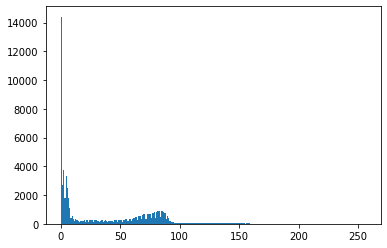

In [63]:
# Histogram
plt.hist(brain_im.ravel(), 256,[0,256]);
plt.show()

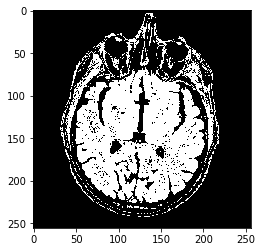

In [64]:
# apply threshold
th_img_wdg = threshold(55, 90, brain_im)
plt.imshow(th_img_wdg, cmap='gray')
plt.show()

# Adaptive thresholding does not make sense since we will have the same intensities in all the image (e.g. no more exposition in a part of the image)

## Thresholding, morphological operators, labeling

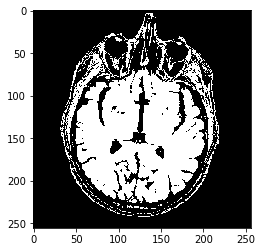

In [65]:
# initial threshold
i_thresholded = threshold(55, 100, brain_im)
# morphological operator kernel
kernel = np.ones((3,3), np.uint8) 
# erosion to separate brain from skull
img_erosion = ndimage.binary_erosion(i_thresholded, kernel, iterations=1) 
plt.figure()
plt.imshow(i_thresholded, cmap='gray')



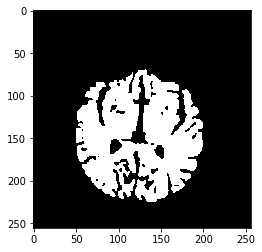

In [66]:
# label features
labeled_array, num_features = ndi.label(img_erosion)
# find brain region = largest connected components
brain_region_label,_ = mode(labeled_array[labeled_array!=0])
# isolate brain region
brain_region = np.where(labeled_array != brain_region_label.item(), 0, img_erosion)
# dilation to restore pixels lost in erosion
brain_region_restored = ndimage.binary_dilation(brain_region, kernel3, iterations=1) 
plt.imshow(brain_region_restored, cmap='gray')

In [67]:
print("brain area is: ", np.sum(brain_region_restored))

brain area is:  14566


## Hybrid method: Thresholding, morphological operators, labeling 

This method includes a series of operations mostly inspired by the work of Somasundarm et al.(reference below). 

The image is first blurred in order to get a rough mask of the brain to be extracted. The mask is then applied to the brain image denoised by the Gaussian filter. 

Next, gray-level erosion is applied to the masked denoised brain image with a flat structuring element. Gray-level erosion is used here because our goal is to get rid of the high-intensity bone structures close to the eyes by taking the local minimum.  The structuring element's shape and gray level are empirically optimized. After the erosion the image is thresholded so that in the resultant binary image majority of the bones is removed.

As it is observed that there are still some tiny connecting parts between the brain and skull bone, we apply a binary erosion with a small structuring element, just enough to separate the connections.

After the brain is disconnected from other unwanted parts, we see that now the brain is the largest connected component apart from the background. With a labeling algorithm we can extract pixels belonging to the brain. Because we know the background is labeled 0 by the algorithm (first pixel of the image is in the background), by taking the mode of labels excluding 0 we should get the brain.

With the brain isolated, the last step is to restore some pixels lost in the binary erosion step, especially pixels around those "holes" inside the brain. The restoration is done by applying a binary dilation with the same structuring element as the previous erosion.

All binary pixels of the processed image are summed up to generate the number of pixels in the brain.

Reference: Somasundaram, K., and P. Kalavathi. 2010. “A Hybrid Method for Automatic Skull Stripping of Magnetic Resonance Images (MRI) of Human Head Scans.” In 2010 Second International Conference on Computing, Communication and Networking Technologies, 1–5. https://doi.org/10.1109/ICCCNT.2010.5592550.


In [68]:
# imports
from skimage import feature
from skimage.morphology import disk
from skimage.filters import rank
from scipy.stats import mode
from scipy import ndimage

# Denoise with Gaussian filter
brain_denoise = cv2.GaussianBlur(brain_im,(5,5),0.5,0.5)

# Threshold helper function
# input: t1 = lower threshold, t2 = higher threshold, img = image
# output: binary image with values of 1 at pixels between the 2 thresholds and 0 elsewhere
def threshold(t1, t2, img):
    th_img = img.copy()
    th_img[th_img < t1] = 0
    th_img[th_img > t2] = 0
    th_img[(th_img >= t1) & (th_img <= t2)] = 1
    return th_img

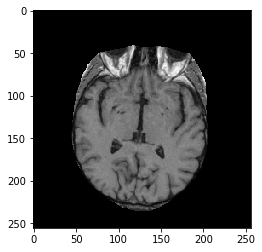

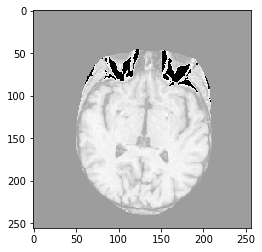

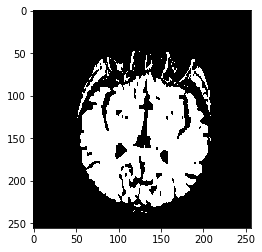

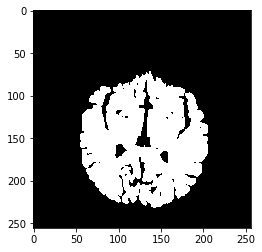

brain area is:  16272  pixels


In [69]:
# blur the image by local mean filtering with circular element
selem = disk(40)
brain_blur = rank.mean(brain_im, selem=selem)
# find a rough mask of the brain with thresholding
i_thresholded = threshold(45, 95, brain_blur)
plt.imshow(brain_denoise*i_thresholded, cmap='gray')
plt.show()

# gray level erosion with structuring element of gray level 99 (empirically optimized)
kernel = np.ones((11,11), np.uint8)*99
rough_mask = brain_denoise*i_thresholded
img_erosion = ndimage.grey_erosion(rough_mask,structure=kernel)
plt.imshow(img_erosion, cmap = 'gray')
plt.show()

# thresholding to extract the brain tissue and use binary erosion to separate the brain tissue from other unwanted pixels
i_thresholded = threshold(210, 255, img_erosion.astype(np.float))
kernel2 = np.ones((3,1), np.uint8)
img_erosion2 = ndimage.binary_erosion(i_thresholded, kernel2, iterations=1).astype(i_thresholded.dtype) 
plt.imshow(img_erosion2, cmap='gray')
plt.show()

# apply labeling algorithm
labeled_array, num_features = ndi.label(img_erosion2)
# find the largest connecting component excluding the background
brain_region_label,_ = mode(labeled_array[labeled_array!=0]) 
brain_region = np.where(labeled_array != brain_region_label.item(), 0, img_erosion2)

# apply dilation to restore brain pixels that may be lost in binary erosion
brain_region_restored= ndimage.binary_dilation(brain_region, kernel2, iterations=1) 
plt.imshow(brain_region_restored,cmap='gray')
plt.show()


# sum up the binary pixels to get brain area in pixels
print("brain area is: ", np.sum(brain_region_restored), " pixels")

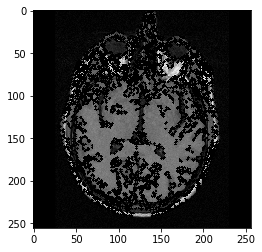

In [70]:
import cv2
i = brain_im.copy()
mask = cv2.Canny(i, 55, 90)
cnts = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

for c in cnts[0]:
    c = cv2.convexHull(c)
    
for c in cnts[0]:
    cv2.drawContours(i, c, -1, (0, 230, 255), 2)
    
plt.figure()
plt.imshow(i, cmap='gray')

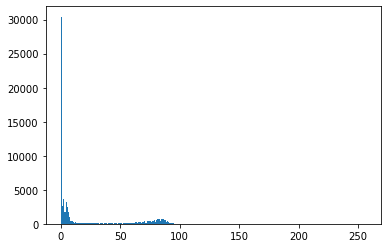

In [71]:
plt.hist(i.ravel(), 256,[0,256])
plt.show()

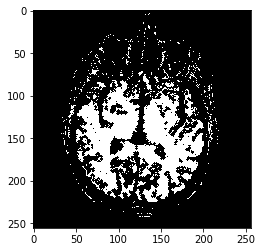

In [72]:
# copy the function threshold above it (you find it below)
i_thresholded = threshold(65, 95, i)
plt.figure()
plt.imshow(i_thresholded, cmap='gray')

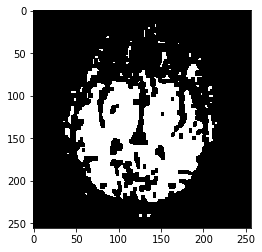

In [73]:
kernel1 = np.ones((2,2), np.uint8) 
kernel2 = np.ones((2,1), np.uint8) 
kernel3 = np.ones((2,2), np.uint8) 


# The first parameter is the original image, 
# kernel is the matrix with which image is  
# convolved and third parameter is the number  
# of iterations, which will determine how much  
# you want to erode/dilate a given image.  
# img_erosion = cv2.erode(i_thresholded, kernel, iterations=1) 
# img_dilation = cv2.dilate(img_erosion, kernel, iterations=1) 

from scipy import ndimage
img_closing = ndimage.binary_closing(i_thresholded, kernel1, iterations=3) 
img_opening = ndimage.binary_opening(img_closing, kernel3, iterations=1) 
img_erosion = ndimage.binary_erosion(img_opening, kernel2, iterations=1) 
    
plt.figure()
plt.imshow(img_erosion, cmap='gray')

In [74]:
type(img_closing)

numpy.ndarray

In [75]:
# Active countours to detect external part of brain, threshold, then segment
# Active Contour segmentation (snakes)
# snake does not work
#rewrite code

def image_show(image, nrows=1, ncols=1, cmap='gray'):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 14))
    ax.imshow(image, cmap='gray')
    ax.axis('off')
    return fig, ax
# fig, ax = image_show(brain_denoise)


def circle_points(resolution, center, radius):
    """
    Generate points which define a circle on an image.Centre refers to the centre of the circle
    """   
    radians = np.linspace(0, 2*np.pi, resolution)
    c = center[1] + radius*np.cos(radians)#polar co-ordinates
    r = center[0] + radius*np.sin(radians)
    
    return np.array([c, r]).T
# Exclude last point because a closed path should not have duplicate points
points = circle_points(300, [148, 124], 81)[:-1]
# ax.plot(points[:, 0], points[:, 1], '--r', lw=3)

# initialize an ellipsoid curve
def ellipse_points(resolution, center, radius, a, b):
    radians = np.linspace(0, 2*np.pi, resolution)
    c = center[1] + a*radius*np.cos(radians)#polar co-ordinates
    r = center[0] + b*radius*np.sin(radians)
    return np.array([c, r]).T

points = ellipse_points(300, [147, 125], 80,0.98,1.03)[:-1]


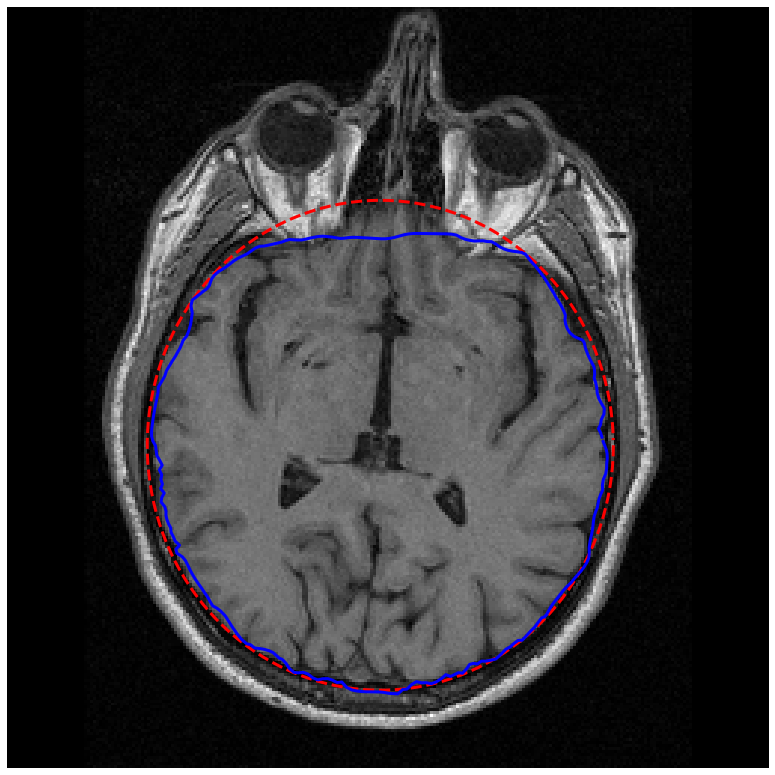

In [76]:
import skimage.segmentation as seg
# snake = skimage.segmentation.active_contour(brain_denoise, points, alpha=0.002, beta=1, gamma=0.001)
snake = seg.active_contour(edges, points, alpha=1.2, beta=0.6, gamma=0.02)
# weighting parameter notes
# alpha = 1st derivative: elongation
# beta = 2nd derivative: curvature
# gamma = g: contour

fig, ax = image_show(brain_im)
ax.plot(points[:, 0], points[:, 1], '--r', lw=3)
ax.plot(snake[:, 0], snake[:, 1], '-b', lw=3);

# todo detect params alpha, beta, gamma

In [77]:
# Random walker


## Part 2: Shape/color segmentation

You will find hereafter three pictures taken under three different illuminations, containing some shapes with different colors. We ask you to create a routine to:

1. Count the number of shapes of each color.
2. Compute the total area (in pixels) of each color.

Please note that one specific challenge is to be robust to illumination changes. Therefore some kind of intensity normalization should probably be used.

**Note:** the routine(s) that you will write for this exercise will be useful for the final project as well, so pay special attention to it.

### 2.1 Visualization

In [78]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)
    
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline
# Load image
data_path = os.path.join(data_base_path, data_folder)
    
# Load images
im_names = ['arena-shapes-01', 'arena-shapes-02', 'arena-shapes-03']
filenames = [os.path.join(data_path, name) + '.png' for name in im_names]
ic = skimage.io.imread_collection(filenames)
images = skimage.io.concatenate_images(ic)
print('Number of images: ', images.shape[0])
print('Image size: {}, {} '.format(images.shape[1], images.shape[2]))
print('Number of color channels: ', images.shape[-1])

Number of images:  3
Image size: 480, 640 
Number of color channels:  3


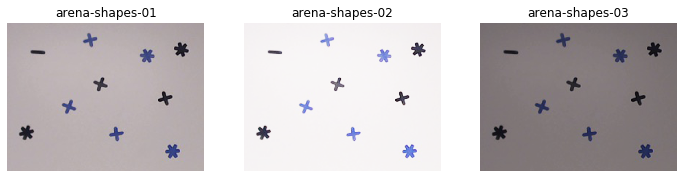

In [79]:
# Plot images
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

In [80]:
# Kmeans method
img = images[0]
kmeans = KMeans(n_clusters=3,random_state=0).fit_predict(img.reshape(-1, 3))

4123


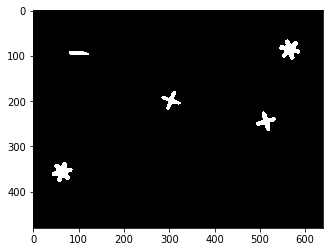

In [81]:
k1 = kmeans.copy()
k1[k1!=1]=0
imk = k1.reshape(img.shape[:2])
imk = ndimage.median_filter(imk, size=4)
plt.imshow(imk, cmap='gray')
print(imk.sum())

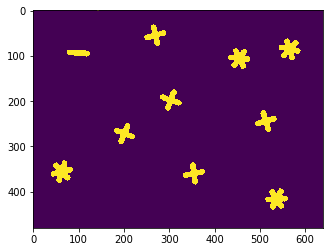

In [82]:
# object mask 
image = cv2.cvtColor(images[2],cv2.COLOR_RGB2GRAY)
mask = (255-cv2.adaptiveThreshold(image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,101,5))/255
plt.imshow(mask)

Number of black object is:  5
Number of blue object is:  5


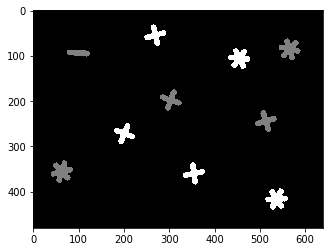

In [83]:
# combine labeling with k means
km = kmeans.copy()
imk = km.reshape(img.shape[:2])
labeled_array, num_features = ndimage.label(mask)
counter = np.zeros(3)
for i in range(1,num_features+1):
    kmeans_label,_ = mode(imk[labeled_array==i])
    labeled_array[labeled_array == i] = kmeans_label
    counter[kmeans_label] += 1
plt.imshow(labeled_array, cmap = 'gray')

print("Number of black object is: ", int(counter[1]))
print("Number of blue object is: ", int(counter[2]))

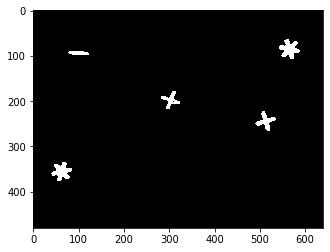

In [18]:
kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(5,5))
k1_open = cv2.morphologyEx(np.float32(k1), cv2.MORPH_OPEN, kernel)
plt.imshow(k1_open.reshape(img.shape[:2]), cmap='gray')

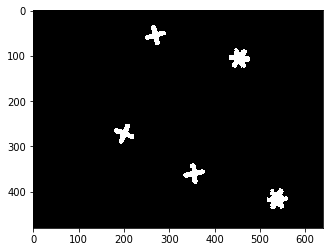

In [85]:
k2=kmeans.copy()
k2[k2!=2]=0
imk = k2.reshape(img.shape[:2])
kernel = np.ones((3,3), np.uint8)
# kernel[1,:]=1
# kernel[:,1]=1
imk = ndimage.binary_opening(imk, kernel, iterations=1) 
plt.imshow(imk, cmap='gray')


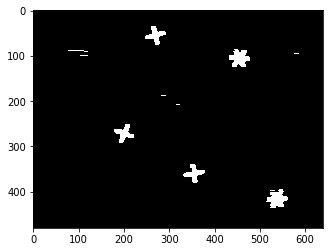

In [86]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(9,9))
k2_open = cv2.morphologyEx(np.float32(k2), cv2.MORPH_OPEN, kernel)
plt.imshow(k2_open.reshape(img.shape[:2]), cmap='gray')

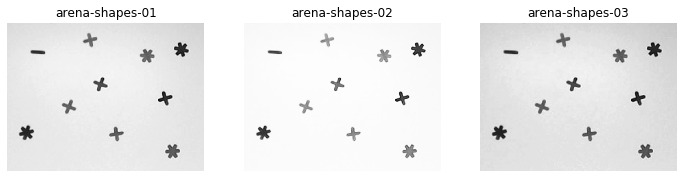

In [87]:
# Plot images
idx=0
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
img=[]
for ax, im, nm in zip(axes.ravel(), images, im_names):
    im = cv2.cvtColor(im,cv2.COLOR_RGB2GRAY)
    img.append(((im -im.min())/(im.max()-im.min())))
    ax.imshow(img[-1],cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
    idx+=1
plt.show()

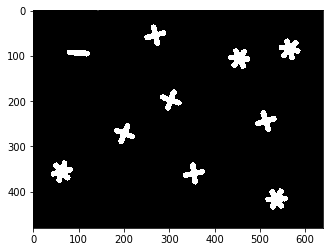

In [88]:
# Adaptive thresholding method
im = cv2.cvtColor(images[2],cv2.COLOR_RGB2GRAY)
it = 255 - cv2.adaptiveThreshold(im,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,101,5)
plt.imshow(it, cmap='gray')

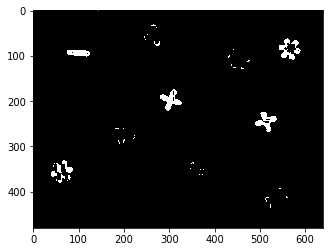

In [89]:
i = images[0] * np.tile(np.expand_dims(it==255,2),(1,1,3))
ihsv = rgb2hsv(i)
plt.imshow((ihsv[:,:,0]>0.7) * 255, cmap='gray')

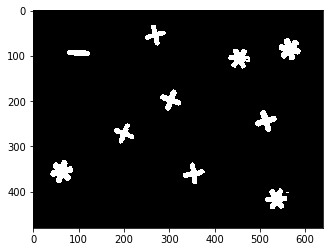

In [90]:
# Threshold to create mask
def threshold(t1, t2, img):
    th_img = img.copy()
    th_img[th_img < t1] = 0
    th_img[th_img > t2] = 0
    th_img[(th_img >= t1) & (th_img <= t2)] = 1
    return th_img

im = images[1][:,:,2]
mask = threshold(1,235,im)
plt.imshow(mask,cmap= 'gray')

[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]


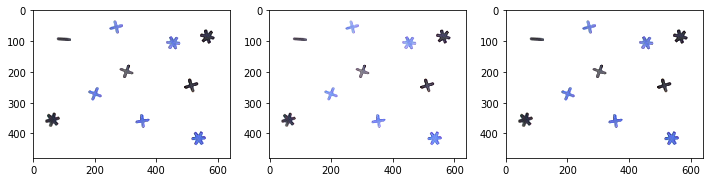

In [91]:
# normalize intensity and white balance on foreground objects
def norm_intensity(img,mask):
    imghsv = rgb2hsv(img)

    fg = imghsv[:,:,2]*mask
    imghsv[:,:,2] = (imghsv[:,:,2] - fg.min())/(fg.max()-fg.min())

    out = hsv2rgb(imghsv)
    out[out > 1] = 1
    out[out < 0] = 0
    return out

# white balance
def wb(channel, perc = 0.05):
    mi, ma = (np.percentile(channel*(mask), perc), np.percentile(channel*(mask),100.0-perc))
    channel = np.uint8(np.clip((channel-mi)*255.0/(ma-mi), 0, 255))
    return channel
fig, axes = plt.subplots(1, 3, figsize=(12, 12))

plt.imshow(mask)

for ax, im  in zip(axes.ravel(), images):
    im_norm = norm_intensity(im,mask)
    imWB  = np.dstack([wb(channel, 0.05) for channel in cv2.split(im)] )
    ax.imshow(imWB)

print(imWB)


### 2.2 Number of shapes of each color
Add your implementation and discussion

### Method 1: Naive solution (threshold + morphological operators)
As a starting point to count the number of shapes of each color, we have tried a naive solution.  The intensity of the image is first normalized; the white of the foreground objects is then balanced. The image is then thresholded in order to create two masks. Each one will contain the respective shapes of "blue" and "gray" objects. Next, different morphological operators are applied to remove undesired artifacts. With the two masks refined, we have therefore counted the number of connected regions to know the number of shapes.

#Shapes in black:  5


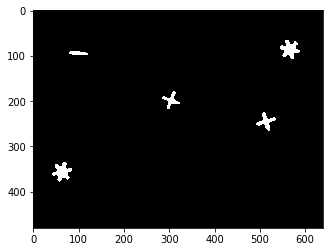

In [93]:
def count_objects(mask, text):
    ''' 
    Function used to count the number of shapes in an image. 
     Args:
            mask (numpy.ndarray): binary image
            text (string): caption to print (e.g. "#Shapes in black: ")

        Returns:
            (void): print the number of connected regions with a caption.
    '''
    labels = skimage.measure.label(mask)
    print(text, labels.max())

# 1. Generate the 2 masks that will contain respectively the "blue" and "gray" shapes  
im_normalized = norm_intensity(images[0],mask)[:, :, 2]
im_normalized = ndimage.median_filter(im_normalized, size = 5)
mask_black_shape = threshold(0.4, 1.0, im_normalized)
mask_blue_shape = threshold(0.4, 0.8,im_normalized)

# swap black and white for morphological operator
mask_black_shape = 1 - mask_black_shape

# 2. Apply morphological operator to refine the mask
kernel = np.ones((3,2), np.uint8)
mask_black_shape = ndimage.binary_closing(mask_black_shape, kernel, iterations=1) 

kernel = np.ones((2,2), np.uint8)
mask_black_shape = ndimage.binary_erosion(mask_black_shape, kernel, iterations=1) 
plt.imshow(mask_black_shape,cmap= 'gray')

# 3. Count the number of shapes that are black
count_objects(mask_black_shape, "#Shapes in black: ")

#Shapes in blue:  5


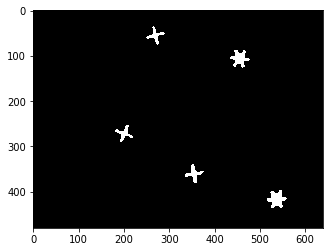

In [94]:
# The process is analogous to the above one
kernel = np.ones((3,3), np.uint8)
mask_blue_shape = ndimage.binary_erosion(mask_blue_shape, kernel, iterations=1) 

kernel = np.ones((6,6), np.uint8)
mask_blue_shape = ndimage.binary_closing(mask_blue_shape, kernel, iterations=1) 

kernel = np.ones((2,2), np.uint8)
mask_blue_shape = ndimage.binary_erosion(mask_blue_shape, kernel, iterations=1) 

plt.imshow(mask_blue_shape,cmap= 'gray')

count_objects(mask_blue_shape, "#Shapes in blue: ")

### Method 2: 

### Method 3:

In [ ]:
# Change from RGB to HSV --> for thresholding e.g. blue --> maybe different shapes but with different colors
# increase brightness

# a. region growing --> count number of pixels
# b. morphological operators --> same #pixels = #same shape
# c. different countour detection --> compare lines to distinguish different shapes
# d. template/pattern + erosion to distinguish the shapes --> convolution?

# STEPS: 1. normalize intensities (??? BIG HOW ???) 2. threshold/filtering to divide by color using HSV [3. shape recognition (a, b, c, d methods)]

### 2.3 Total area (in pixels) of each color
Add your implementation and discussion

### Method 1: Use naive solution of exercise 2.2
The total area of each color can be easily found, counting the number of pixels set to "True" (foreground).

In [105]:
print("#Black pixels:", np.sum(mask_black_shape[mask_black_shape == True]))
print("#Blue pixels: ", np.sum(mask_blue_shape[mask_blue_shape == True]))

#CHECK??? the result is really different from the below!

#Black pixels: 3533
#Blue pixels:  3401


### Method X: Use labeling and K means solution of exercise 2.2

In [106]:
# from labeling + K means result
print("Total area of black is", np.sum(labeled_array[labeled_array == 1]))
print("Total area of blue is", int(np.sum(labeled_array[labeled_array == 2])/2))

Total area of black is 5422
Total area of blue is 5772


In [ ]:
# Finish coding by 3/22 Sunday and start cleaning up/writing report
# Write about why you chose the method, why it would work, how it performed etc.
# Meet again Tuesday 3/31 ：）

3533